In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import tqdm
from scipy.stats import uniform
from IPython.display import display, Math


# defining the function to evaluate, the log likelihood and the priors
def func(time,t0,b,A,alpha):
    return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))

def log_likelihood(x,time,flux,flux_err):
    t0, b, A, alpha = x
    return np.sum(-0.5 * np.log(2*np.pi*flux_err**2) - ((flux - func(time, t0, b, A, alpha))**2) / (2*flux_err**2))

def prior(x):
    bounds=[[0,100],[0,50],[0,50],[-5,5]]
    return (np.prod([uniform.pdf(x[i],loc=bounds[i][0],scale=bounds[i][1]-bounds[i][0]) for i in range(3)])*
            (uniform.pdf(np.log(x[3]),loc=bounds[3][0],scale=bounds[3][1]-bounds[3][0]))/x[3])

# creating a function that initialize the walkers for each parameter
def generate_initial_walkers(nwalkers):
    t0_vals = np.random.uniform(0, 100, size=nwalkers)
    b_vals = np.random.uniform(0, 50, size=nwalkers)
    A_vals = np.random.uniform(0, 50, size=nwalkers)
    alpha_vals = np.exp(np.random.uniform(-5, 5, size=nwalkers))
    return np.column_stack([t0_vals, b_vals, A_vals, alpha_vals])

# evaluating the log posterior
def logposterior(x, time, flux, flux_err):
    p = prior(x)
    if p == 0 or np.isnan(p):
        return -np.inf  # log(0) è non definito
    return np.log(p) + log_likelihood(x, time, flux, flux_err)


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Flux')]

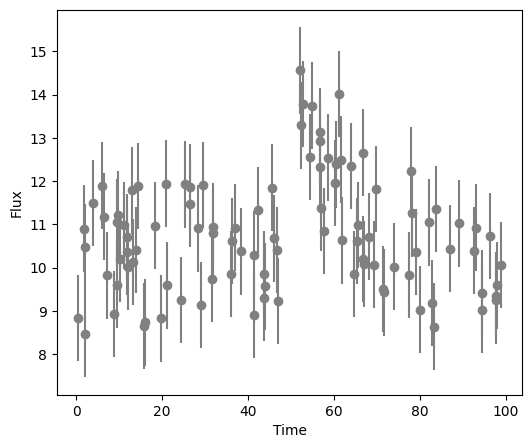

In [3]:
data=np.load('Datasets/transient.npy')
time=data[:,0]
flux=data[:,1]
flux_err=data[:,2]

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.errorbar(time,flux,yerr=flux_err,marker='o',color='grey',linestyle='')
ax.set(xlabel='Time',ylabel='Flux')

In [ ]:
ndim=4
nwalkers=10
burn=10000
nsteps=200000
# running the MCMC (it takes a while)
starting_guesses = generate_initial_walkers(nwalkers)
sampler=emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[time,flux,flux_err])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

/tmp/ipykernel_2450/3392478692.py:12: RuntimeWarning: overflow encountered in exp
  return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))
/tmp/ipykernel_2450/3392478692.py:12: RuntimeWarning: overflow encountered in multiply
  return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))
  0%|          | 0/200000 [00:00<?, ?it/s]/tmp/ipykernel_2450/3392478692.py:21: RuntimeWarning: invalid value encountered in log
  (uniform.pdf(np.log(x[3]),loc=bounds[3][0],scale=bounds[3][1]-bounds[3][0]))/x[3])
100%|██████████| 200000/200000 [29:54<00:00, 111.43it/s]


State([[48.20606308 10.3697017   6.6815321   0.13510341]
 [47.4325374  10.13075176  9.52496641  0.17059865]
 [51.87144882 10.06400627  4.76108201  0.13628993]
 [48.46820438 10.3660907   5.8211164   0.1227304 ]
 [51.2735104  10.22260922  4.30796393  0.09638218]
 [49.3594631  10.40484752  4.00700687  0.10365694]
 [51.60267532 10.32451194  4.01993623  0.12736765]
 [49.79973703 10.23062386  5.55911409  0.09641932]
 [48.77180223 10.36449015  5.65716791  0.1361912 ]
 [48.95117059 10.55627053  4.60754436  0.10401121]], log_prob=[-153.68357411 -157.81448459 -156.28681195 -153.49480647 -154.09157011
 -154.70009811 -153.42818656 -156.45540814 -153.98780056 -156.814045  ], blobs=None, random_state=('MT19937', array([1319582159, 2702671761, 2276540240, 3607320112, 3040411992,
       3114696546, 3561342356, 1327328529,  252662628,  298549387,
       1005437897, 3877929625, 3016607794, 2626717833, 1266168694,
       3495237442, 3720324628, 1387073606, 2306963213, 4170275445,
       3266173996,  4259

In [5]:
# discarting the burn-in phase and thinning the chain
burn=10000
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print(sampler.chain.shape)
print(emcee_trace.shape)

emcee_trace.flatten()
len(emcee_trace.flatten())

tau = sampler.get_autocorr_time()
print(tau)
thin = int(np.max(tau)+1)


(10, 200000, 4)
(1900000, 4)
[1130.7407518   866.35799755 1259.34955123 2812.51881591]


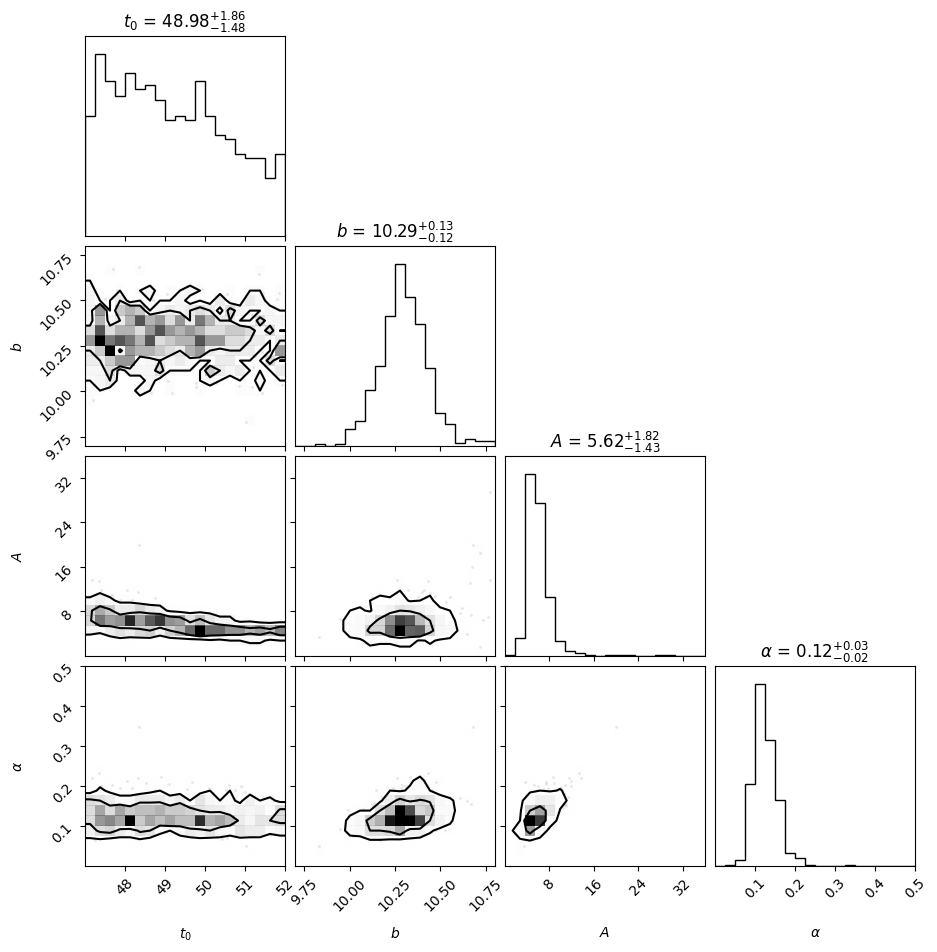

In [6]:
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True)
ranges = [(47, 52),(9.7, 10.8),(0, 36),(0, 0.5)]

# plotting a corner plot for all the parameters
labels = ["$t_0$", "$b$", "$A$", r"$\alpha$"]
fig = corner.corner(emcee_trace, labels=labels, range=ranges,
                    levels=[0.68,0.95],
                    show_titles=True, title_fmt=".2f", 
                    title_kwargs={"fontsize": 12})

/tmp/ipykernel_2450/3392478692.py:12: RuntimeWarning: overflow encountered in exp
  return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))
/tmp/ipykernel_2450/3392478692.py:12: RuntimeWarning: overflow encountered in multiply
  return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Flux')]

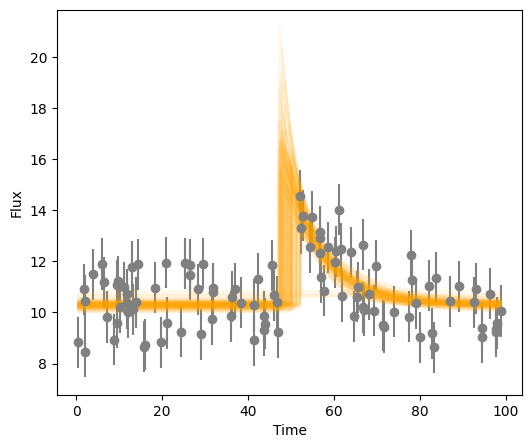

In [11]:
# plotting 100 random distributions from those that has been generated
N=100
fig,ax = plt.subplots(1,1,figsize=(6,5))
index = np.random.choice(len(emcee_trace), N, replace=False)
x=np.linspace(min(time),max(time),1000)
ax.errorbar(time,flux,yerr=flux_err,marker='o',color='grey',linestyle='')
for i in index:
    sample = emcee_trace[i]
    model_flux = func(x, *sample)
    ax.plot(x, model_flux, color='orange', alpha=0.1)
ax.set(xlabel='Time',ylabel='Flux')

In [17]:
# printing the median and the 90% credible region
for i, name in enumerate(labels):
    mcmc = np.percentile(emcee_trace[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    display(Math(r'${0}={1:.2f}^{{+{2:.2f}}}_{{-{3:.2f}}}$'.format(
        name, mcmc[1], q[1], q[0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>